In [ ]:
import coreferee
import spacy
import pandas as pd 
import re
import os
import csv
import nltk
from nltk.tokenize import sent_tokenize
from itertools import combinations
from collections import Counter
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
from nltk import sent_tokenize
import requests
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap
from flair.data import Sentence
from flair.models import SequenceTagger
tagger = SequenceTagger.load("flair/ner-english-large")

nltk.download('punkt')

In [3]:
with open(books_directory+'/'+filename+'.txt', 'r', encoding='latin-1') as file:
    book = file.read()


book_title = filename


pattern = re.compile(r'CHAPTER (\d+|I{1,3}|IV|V|VI{0,3}|IX|X|XI{0,3}|XIV|XV|XVI{0,3}|XIX|XX|XXX|XL)', re.IGNORECASE)

def split_into_chunks(text, max_length=13000):
    sentences = sent_tokenize(text)
    chunks = []
    current_chunk = []
    current_length = 0

    for sentence in sentences:
        if current_length + len(sentence) + 1 > max_length:
            chunks.append(" ".join(current_chunk))
            current_chunk = []
            current_length = 0
        current_chunk.append(sentence)
        current_length += len(sentence) + 1  # +1 for space or punctuation

    if current_chunk:
        chunks.append(" ".join(current_chunk))

    return chunks

if pattern.search(book):
    chapters = pattern.split(book)
    processed_chapters = []
    for i in range(1, len(chapters), 2):
        chapter_number = chapters[i]
        chapter_content = chapters[i + 1]
        processed_chapters.append(chapter_content.strip())
    chapters = processed_chapters
else:
    # If no pattern match, split the text into manageable chunks
    chapters = split_into_chunks(book)

In [4]:
with open(directory+'/honorifics.txt', 'r', encoding='latin-1') as file:
    honorifics_list = [honorific.strip() for line in file for honorific in line.split(',')]

In [5]:
person_entities = []
location_entities = []

for chapter in chapters:
    t = Sentence(chapter)
    tagger.predict(t)
    sentence_text = t.to_plain_string()
    words = sentence_text.split()  
    for entity in t.get_spans('ner'):
        if entity.tag == 'PER':
            token_index_str = str(entity.tokens[0])
            token_index = int(token_index_str.split('[')[1].split(']')[0])
            previous_token = t.get_token(token_index)  # Get the previous token
            if previous_token is not None and previous_token.text in honorifics_list:
                person_entities.append(previous_token.text + " " + entity.text)
            elif previous_token is not None:
                person_entities.append(entity.text)
        if entity.tag == 'LOC':
            location_entities.append(entity.text)


person_counts = pd.Series(person_entities).value_counts()
location_counts = pd.Series(location_entities).value_counts()

df_person = pd.DataFrame({'Person': person_counts.index, 'Count': person_counts.values})
df_location = pd.DataFrame({'Location': location_counts.index, 'Count': location_counts.values})

print("Person Counts:")
print(df_person)
print("\nLocation Counts:")
print(df_location)

Person Counts:
            Person  Count
0     Mr. Utterson     69
1            Poole     61
2         Utterson     60
3             Hyde     41
4           Jekyll     40
..             ...    ...
59              Mr      1
60       Mr. Guest      1
61          Coutts      1
62          LANYON      1
63  HENRY JEKYLL'S      1

[64 rows x 2 columns]

Location Counts:
             Location  Count
0              London     11
1                Soho      7
2    Cavendish Square      2
3           Edinburgh      1
4          Black Mail      1
5               House      1
6        Queer Street      1
7        Gaunt Street      1
8      Scotland\ Yard      1
9              Heaven      1
10  Cavendish\ Square      1
11           Philippi      1
12         mid-London      1
13             Jekyll      1
14      Regent's Park      1
15    Portland Street      1


In [6]:
char_list = df_person['Person'].tolist()

for index, row in df_person.iterrows():
    person = row['Person']
    person_count = row['Count']
    if person in df_location['Location'].tolist():
        location_count = df_location[df_location['Location'] == person]['Count'].values[0]
        if location_count > person_count:
            print("Removed entity:",person)
            char_list.remove(person)

print(sorted(char_list))

['.', 'Bless God', 'Bradshaw', 'Cain', 'Carew', 'Coutts', 'DR', 'Damon', 'Danvers Carew', 'Dr.', 'Dr. Denman', 'Dr. Fell', 'Dr. Henry Jekyll', 'Dr. Henry\\ Jekyll', 'Dr. J.', 'Dr. Jekyll', 'Dr. Lanyon', 'Dr.\\', 'Dr.\\ Jekyll', 'Edward Hyde', 'Enfield', 'G. J. Utterson', 'Gabriel John Utterson', 'God', 'Good God', 'Guest', 'H.J', 'HASTIE LANYON', 'HENRY JEKYLL', "HENRY JEKYLL'S", 'HYDE', 'Harry', 'Harry Jekyll', 'Harry\\ Jekyll', 'Henry Jekyll', 'Henry\\ Jekyll', 'Hyde', 'Inspector Newcomen', 'JEKYLL', 'Jekyll', 'LANYON', "LANYON'S", 'Lanyon', 'Master Hyde', 'Maw', 'Messrs. M.', 'Mr', 'Mr.', 'Mr. Enfield', 'Mr. Guest', 'Mr. Hyde', 'Mr. Richard Enfield', 'Mr. Seek', 'Mr. Utterson', 'O', 'PEDE', 'Poole', 'Pythias', 'Richard', 'Satan', 'Sawbones', 'Sir Danvers', 'Utterson', '\\']


In [7]:
class TextProcessor:
    def __init__(self, lst, special_characters, honorifics_list):
        self.lst = lst
        self.special_characters = special_characters
        self.honorifics = honorifics_list
        self.removed_entities = []
        self.modified_entities= []

    def remove_uppercased_terms(self):
        self.removed_entities.extend([term for term in self.lst if term.isupper()])
        self.lst = [term for term in self.lst if not term.isupper()]
    
    def remove_non_title_cased_terms(self):
        def has_title_cased_word(term):
            return any(word.istitle() for word in term.split())

        self.lst = [term for term in self.lst if has_title_cased_word(term)]
        
    def split_entities_on_conjunction(self):
        split_entities = []
        for term in self.lst:
            if ' and ' in term:
                split_entities.extend(term.split(' and '))
            else:
                split_entities.append(term)
        self.lst = split_entities     
        
    def remove_only_special_characters_terms(self):
        pattern = r'^[' + re.escape(''.join(self.special_characters)) + r']+$'
        self.removed_entities.extend([term for term in self.lst if re.match(pattern, term) or len(term) == 1])
        self.lst = [term for term in self.lst if not (re.match(pattern, term) or len(term) == 1)]

    def remove_special_characters(self):
        pattern = r'[{}]'.format(re.escape(''.join(self.special_characters)))
        index = 0

        while index < len(self.lst):
            term = self.lst[index]
            if re.search(pattern, term):
                self.modified_entities.append(term)
                split_terms = re.split(pattern, term)
                self.lst.pop(index)
                for split_term in reversed(split_terms):
                    if split_term:  # Skip empty strings
                        self.lst.insert(index, split_term)
                index += len(split_terms) - 1
            else:
                index += 1

    def remove_special_characters_from_end(self):
        pattern = r'[{}]+$'.format(re.escape('.'))
        for term in self.lst:
            if re.search(pattern, term):
                self.modified_entities.append(term)
        self.lst = [re.sub(pattern, '', term) for term in self.lst]


    def remove_only_honorific_terms(self):
        self.removed_entities.extend([term for term in self.lst if term in self.honorifics])
        self.lst = [term for term in self.lst if term not in self.honorifics]

    def remove_multiple_whitespaces(self):
        self.lst = [' '.join(term.split()) for term in self.lst]

    def remove_partial_terms_with_articles(self):
        for i, term in enumerate(self.lst):
            modified_term = re.sub(r'^(the|a|an)\b\s*', '', term, flags=re.IGNORECASE)
            if modified_term != term:
                self.modified_entities.append(term)
                self.lst[i] = modified_term

    def remove_nobody(self):
        forbidden_terms = ['nobody', 'why', 'come', 'people', 'by', 'god', 'good','your','by', 'my','heaven','bless', 'dear', 'pray', 'i', 'you', 'me', 'he', 'she', 'they', 'us', 'we']
        self.lst = [phrase for phrase in self.lst if not any(term.lower() in forbidden_terms for term in phrase.lower().split())]
        
    def remove_empty_terms(self):
        # Remove empty terms from the list
        self.lst = [term for term in self.lst if term.strip()]        
    def remove_non_title_cased_words(self):
        def keep_title_cased_words(term):
            return ' '.join(word for word in term.split() if word.istitle() )
        self.lst = [keep_title_cased_words(term) for term in self.lst]
special_characters = ['!', '"', '#', '$', '%', '&', '(', ')', '*', '+', ',','/', ':', ';', '<', '=', '>', 
                      '?', '@', '[', '\\', ']', '^', '_', '{', '|', '}', '~']


def process_text_list(lst):
    processor = TextProcessor(lst, special_characters, honorifics_list)
    processor.remove_uppercased_terms()
    processor.remove_non_title_cased_terms()
    processor.split_entities_on_conjunction()
    processor.remove_only_special_characters_terms()
    processor.remove_special_characters()
    processor.remove_multiple_whitespaces()
    processor.remove_partial_terms_with_articles()
    processor.remove_special_characters_from_end()
    processor.remove_nobody()
    processor.remove_non_title_cased_words()
    processor.remove_only_honorific_terms()
    processor.remove_empty_terms()
    return list(set(processor.lst)) 

character_list=process_text_list(char_list)


print(sorted(character_list))

['Bradshaw', 'Cain', 'Carew', 'Coutts', 'Damon', 'Danvers Carew', 'Dr. Denman', 'Dr. Fell', 'Dr. Henry', 'Dr. Henry Jekyll', 'Dr. J', 'Dr. Jekyll', 'Dr. Lanyon', 'Edward Hyde', 'Enfield', 'G. J. Utterson', 'Gabriel John Utterson', 'Guest', 'Harry', 'Harry Jekyll', 'Henry', 'Henry Jekyll', 'Hyde', 'Inspector Newcomen', 'Jekyll', 'Lanyon', 'Master Hyde', 'Maw', 'Messrs. M', 'Mr. Enfield', 'Mr. Guest', 'Mr. Hyde', 'Mr. Richard Enfield', 'Mr. Seek', 'Mr. Utterson', 'Poole', 'Pythias', 'Richard', 'Satan', 'Sawbones', 'Sir Danvers', 'Utterson']


In [14]:
#before download the webdriver for your chrome version 
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from bs4 import BeautifulSoup
import time

def search_sparknotes(book_title):
    chrome_options = Options()
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")

    service = Service(directory+"/chromedriver")  

    try:
        driver = webdriver.Chrome(service=service, options=chrome_options)

        driver.get("https://www.sparknotes.com/")
        print("Accessed SparkNotes website")

        # Wait for the search bar to be present
        search_bar = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.ID, "heroSearch"))
        )
        print("Search bar found")

        # Enter the book title in the search bar and submit the search
        search_bar.clear()
        search_bar.send_keys(book_title)
        search_bar.send_keys(Keys.RETURN)
        print("Search submitted")

      # Check and close the consent banner if it appears
        try:
            consent_banner = WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.ID, "onetrust-accept-btn-handler"))
            )
            consent_banner.click()
            print("Consent banner closed")
        except:
            print("No consent banner found")

        driver.execute_script("""
            var overlays = document.querySelectorAll('#onetrust-banner-sdk, #onetrust-policy, #onetrust-policy-text');
            overlays.forEach(function(overlay) {
                overlay.style.display = 'none';
            });
        """)

        # Find and click the "Full Text" link for the book
        full_text_link = WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.XPATH, "//a[contains(@href, 'full-text') and contains(., 'Full Text')]"))
        )
        full_text_link.click()
        print("Clicked on 'Full Text' link")

        driver.execute_script("""
            var overlays = document.querySelectorAll('#onetrust-banner-sdk, #onetrust-policy, #onetrust-policy-text');
            overlays.forEach(function(overlay) {
                overlay.style.display = 'none';
            });
        """)

        # Construct the URL for the character list page dynamically
    
        current_url = driver.current_url
        match = re.search(r'/lit/([^/]+)/full-text', current_url)
        if match:
            book_slug = match.group(1)
            character_list_url = f"/lit/{book_slug}/characters"
            driver.execute_script(f"window.location.href = '{character_list_url}';")
            print(f"Navigated directly to '{book_title}' Character List page")
        else:
            print("Could not determine book character list.")

        # Wait for the characters section to be loaded
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "mainTextContent__list-content__item__heading"))
        )
        print("Characters section found")

        # Get the book page content after navigation
        book_page_content = driver.page_source
        soup = BeautifulSoup(book_page_content, 'html.parser')

        # Find the characters section
        characters_section = soup.find('div', {'class': 'mainTextContent'})

        if not characters_section:
            print("Characters section not found.")
            return []

        # Extract the character names
        characters = []
        for char_name in characters_section.find_all('h3', {'class': 'mainTextContent__list-content__item__heading'}):
            characters.append(char_name.get_text().strip())

        return characters

    except Exception as e:
        print("Error during scraping:", e)
        return []

    finally:
        try:
            driver.quit()
        except:
            pass


book_title = filename
sparknotes_characters = search_sparknotes(book_title)

sparknotes_characters

Accessed SparkNotes website
Search bar found
Search submitted
Consent banner closed
Clicked on 'Full Text' link
Navigated directly to 'The Strange Case Of Dr. Jekyll And Mr. Hyde' Character List page
Characters section found


['Dr. Henry Jekyll',
 'Mr. Edward Hyde',
 'Mr. Gabriel John Utterson',
 'Dr. Hastie Lanyon',
 'Mr. Poole',
 'Mr. Enfield',
 'Mr. Guest',
 'Sir Danvers Carew']

In [15]:
# Function to remove honorific from a name
def remove_honorific(name, honorifics_list):
    words = name.split()
    if words[0] in honorifics_list:
        return ' '.join(words[1:])
    else:
        return name

# Remove honorifics from all names
sparknotes_characters = [remove_honorific(name, honorifics_list) for name in sparknotes_characters]
sparknotes_characters

['Henry Jekyll',
 'Edward Hyde',
 'Gabriel John Utterson',
 'Hastie Lanyon',
 'Poole',
 'Enfield',
 'Guest',
 'Danvers Carew']

In [16]:
#look at the recall because generally character list on sparknotes is limited to the most important characters.
clus_entities = set(character_list)
clus_entities= [remove_honorific(name, honorifics_list) for name in clus_entities]
def calculate_metrics(golden_list, mylist):
    true_positives = len([x for x in mylist if x in golden_list])
    false_positives = len([x for x in mylist if x not in golden_list])
    false_negatives = len([x for x in golden_list if x not in mylist])

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) != 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) != 0 else 0

    return precision, recall, f1_score

NERprecision, NERrecall, NERf1_score= calculate_metrics(sparknotes_characters, clus_entities)
print("Precision:",NERprecision, "Recall:",NERrecall, "F1_Score:",NERf1_score)
data = [
    ("Precision",NERprecision,'flair/ner-english-large'),
    ("Recall", NERrecall,'flair/ner-english-large'),
    ("F1_Score", NERf1_score,'flair/ner-english-large')
]


Precision: 0.23809523809523808 Recall: 0.9090909090909091 F1_Score: 0.3773584905660377


In [17]:
[e for e in sparknotes_characters if e not in character_list]

['Hastie Lanyon']

In [18]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")
import matplotlib.pyplot as plt

nlp_sent = spacy.load('en_core_web_sm')
def split_text(text, max_length):
    return [text[i:i + max_length] for i in range(0, len(text), max_length)]


def divide_text_into_chunks(segment, max_tokens=412, overlap=1):
    doc = nlp_sent(segment)
    sentences = list(doc.sents)
    
    chunks = []
    current_chunk = []
    current_length = 0

    for i, sentence in enumerate(sentences):
        sentence_tokens = tokenizer.encode(sentence.text, add_special_tokens=False)
        if current_length + len(sentence_tokens) > max_tokens:
            if current_chunk:
                chunks.append(current_chunk[:])
                current_chunk = current_chunk[-overlap:]
                current_length = sum(len(tokenizer.encode(sent.text, add_special_tokens=False)) for sent in current_chunk)
        
        current_chunk.append(sentence)
        current_length += len(sentence_tokens)
    
    if current_chunk:
        chunks.append(current_chunk[:])
    
    return chunks


max_spacy_length = 1000000  
segments = split_text(book, max_spacy_length)

all_chunks = []
for segment in segments:
    chunks = divide_text_into_chunks(segment)
    all_chunks.extend(chunks)


num_sentences_per_chunk = [len(chunk) for chunk in all_chunks]

In [19]:
char_list3 = []
ents=[]
if(len(sparknotes_characters)!=0):

    for chunk in all_chunks:
        input_text = """
        Answer the following question:
        Are there character entities? Return the character entities with their nicknames. 
        If there are no characters return 'nobody'. 
        Do not return pronouns in your answer as character entities, but 'nobody'.
        Excerpt:
        """ + str(chunk)

        input_ids = tokenizer(input_text, return_tensors="pt").input_ids
        outputs = model.generate(input_ids, max_length=200, temperature=0.0)
        decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(decoded_output)
        entities = [entity.strip() for entity in decoded_output.split(",")]
        char_list3.extend(entities)
        ents.append(decoded_output)
else:
    pass

Mr. Utterson, the lawyer
Mr. Utterson
Mr. Utterson
Richard Enfield
Mr. Enfield
Mr. Enfield, Mr. Utterson
the Sawbones
Sawbones
Coutts's,
Mr. Enfield
Enfield, Hyde
Hyde
Dr. Jekyll
Dr. Jekyll, M.D., D.C.L., L.L.D., F.R.S.
Dr. Lanyon
Dr. Lanyon, Henry Jekyll
Mr. Utterson, Hyde
Mr. Enfield, Juggernaut
Mr. Hyde
Mr. Hyde, Mr. Seek
Mr. Hyde
Dr. Jekyll, Mr. Hyde
Mr. Hyde, Jekyll
Harry Jekyll
Dr. Jekyll
Dr. Jekyll, Mr. Hyde
Harry Jekyll, Master Hyde
Harry, Jekyll, Hyde
Dr. Jekyll, Lanyon
Dr. Jekyll, Hyde
Utterson, Hyde
Jekyll
Mr. Hyde
Mr. Hyde
Sir Danvers Carew
Mr. Hyde, Mr. Jekyll
Mr. Utterson
Henry Jekyll
Mr. Hyde, Inspector Newcomen
Henry Jekyll
Dr. Jekyll, Poole
Dr. Jekyll, Mr. Utterson
Jekyll, Hyde
Dr. Jekyll
Utterson
Mr. Guest
Mr. Guest, Mr. Hyde
Dr. Jekyll
Henry Jekyll, Mr. Hyde
Dr. Jekyll, Lanyon
Dr. Jekyll
Dr. Jekyll, Lanyon
Jekyll, Hyde
G. J. Utterson, Henry Jekyll
Poole
Dr. Jekyll
Dr. Jekyll
Poole
Poole, Mr. Utterson
Mr. Utterson, Poole
Poole, Mr. Utterson
Poole, Mr. Utterson
Mr. Utt

In [20]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large")


loc_list3 = []
l_ents=[]
if(len(sparknotes_characters)!=0):
    for chunk in all_chunks:
        input_text = """
        Answer the following question:
        Are there location entities? Return the location entities. 
        If there are no locations return 'no location'. 
        Excerpt:
        """ + str(chunk)

        input_ids = tokenizer(input_text, return_tensors="pt").input_ids
        outputs = model.generate(input_ids, max_length=200, temperature=0.0)
        decoded_output = tokenizer.decode(outputs[0], skip_special_tokens=True)
        print(decoded_output)
        entities_loc = [entity.strip() for entity in decoded_output.split(",")]
        loc_list3.extend(entities_loc)

    location_counts = pd.Series(loc_list3).value_counts()
    location_counts
else:
    pass

no location
no location
no location
London
by-street
no location
Edinburgh
London
cellar
no location
Queer Street
no location
no location
no location
Cavendish Square
no location
church
city
no location
London
no location
Soho
no location
no location
London
London
no location
no location
no location
no location
no location
London
no location
no location
police station
no location
Soho
Soho
Scotland
no location
no location
theatre
no location
no location
no location
London
no location
no location
Soho
no location
no location
no location
no location
business room
no location
court
court
no location
no location
London
no location
laboratory building
laboratory building
house
town
Maw's
no location
theatre
no location
laboratory
London
no location
London
cellar
no location
fireside
no location
no location
no location
Cavendish Square
no location
Cavendish Square
no location
London
no location
floor
no location
compound
no location
no location
no location
no location
no location
no location

no location            66
London                 14
Soho                    8
house                   3
Cavendish Square        3
laboratory              2
laboratory building     2
theatre                 2
court                   2
cellar                  2
city                    1
fireside                1
Portland Street         1
sun on a bench          1
Regent's Park           1
Jekyll                  1
house in the square     1
compound                1
floor                   1
by-street               1
police station          1
Maw's                   1
town                    1
Edinburgh               1
Queer Street            1
business room           1
church                  1
Scotland                1
inn                     1
Name: count, dtype: int64

In [21]:
person_counts = pd.Series(char_list3).value_counts()
df_person = pd.DataFrame({'Person': person_counts.index, 'Count': person_counts.values})
df_location = pd.DataFrame({'Location': location_counts.index, 'Count': location_counts.values})

char_list3 = df_person['Person'].tolist()

# Check for entities in df_person also present in df_location with higher counts
for index, row in df_person.iterrows():
    person = row['Person']
    person_count = row['Count']
    if person in df_location['Location'].tolist():
        location_count = df_location[df_location['Location'] == person]['Count'].values[0]
        if location_count > person_count:
            print("Removed entity:",person)
            char_list3.remove(person)

print(sorted(set(char_list3)))

['', "Coutts's", 'D.C.L.', 'Dr. Henry Jekyll', 'Dr. Jekyll', 'Dr. Lanyon', 'Edward Hyde', 'Enfield', 'F.R.S.', 'G. J. Utterson', 'God', 'HENRY JEKYLL', 'Harry', 'Harry Jekyll', 'Henry Jekyll', 'Hyde', 'I', 'Inspector Newcomen', 'Jekyll', 'Juggernaut', 'L.L.D.', 'Lanyon', 'M.D.', 'Master Hyde', 'Mr. Enfield', 'Mr. Guest', 'Mr. Hyde', 'Mr. Jekyll', 'Mr. Seek', 'Mr. Utterson', 'Poole', 'Richard Enfield', 'Sawbones', 'Sir Danvers Carew', 'Utterson', 'advanced infallibly in one direction and in one direction only.', 'faggots', 'for my part', 'from the nature of my life', 'my butler', 'no man morally sane', 'no one', 'nobody', 'the Sawbones', 'the doctor', 'the lawyer', 'the salt', 'the servant', 'the tincture']


In [22]:
character_list3=process_text_list(char_list3)

print(sorted(character_list3))

['Dr. Henry Jekyll', 'Dr. Jekyll', 'Dr. Lanyon', 'Edward Hyde', 'Enfield', 'G. J. Utterson', 'Harry', 'Harry Jekyll', 'Henry Jekyll', 'Hyde', 'Inspector Newcomen', 'Jekyll', 'Juggernaut', 'Lanyon', 'Master Hyde', 'Mr. Enfield', 'Mr. Guest', 'Mr. Hyde', 'Mr. Jekyll', 'Mr. Seek', 'Mr. Utterson', 'Poole', 'Richard Enfield', 'Sawbones', 'Sir Danvers Carew', 'Utterson']


In [23]:
clus_entities3 = set(character_list3)
clus_entities3= [remove_honorific(name, honorifics_list) for name in clus_entities3]
NER3precision, NER3recall, NER3f1_score = calculate_metrics(sparknotes_characters, clus_entities3)
print("Precision:",NER3precision, "Recall:",NER3recall, "F1_Score:",NER3f1_score)
data = [
    ("Precision",NER3precision,'google/flan-t5-large'),
    ("Recall", NER3recall,'google/flan-t5-large'),
    ("F1_Score", NER3f1_score,'google/flan-t5-large')
]

Precision: 0.3076923076923077 Recall: 0.8 F1_Score: 0.4444444444444444


In [24]:
nlp = spacy.load('en_core_web_sm')

def contains_verb(sentence):
    verbs = {'cried', 'asked', 'shouted', 'answered', 'said', 'replied', 
             'whispered', 'screamed', 'yelled', 'shrieked', 'listenend'}
    
    lemmatizer = WordNetLemmatizer()
    lemmatized_verbs = {lemmatizer.lemmatize(verb) for verb in verbs}
    words = re.findall(r'\b\w+\b', sentence.lower())
    lemmatized_words = {lemmatizer.lemmatize(word) for word in words}
    
    for word in lemmatized_words:
        if word in verbs:
            return word, True
        else:
            for verb in lemmatized_verbs:
            # Find synonyms of the verbs using WordNet
                synsets = wordnet.synsets(verb, pos=wordnet.VERB)
                for synset in synsets[:1]:
                    for lemma in synset.lemmas():
                        if lemma.name()==word:
                            return word, True
    
    return None, False
def is_subject_of_verb(sentence, verb):
    doc = nlp(sentence)
    sub= None
    for token in doc:
        if token.text == verb:
            for child in token.children:
                if (child.dep_ == 'nsubj' or child.dep_ == 'dobj')and child.text.istitle() : 
                    sub=child.text
                    punct=' '
                    
                    for ch in child.children:
                        if ch.dep_=='punct' and ch.text=='-':
                            punct=ch.text
                    for ch in child.children:
                        if ch.dep_=='compound' and ch.text.istitle():
                            sub=ch.text+punct+child.text 
                            for c in ch.children:
                                if c.dep_ == 'compound' and c.text.istitle():
                                    subject=c.text+punct+ch.text+punct+child.text
                            
        if sub:
            return sub
    return ''
    

sentences = sent_tokenize(book)

df = pd.DataFrame({'Sentence': sentences})
# Define a regular expression pattern to remove text within quotes
pattern = r'\".*?\"'

def remove_text_within_quotes(text):
    return re.sub(pattern, '', text)

df['Sent'] = df['Sentence'].apply(remove_text_within_quotes)
df['Sent'] = df['Sent'].str.strip()
# Apply the contains_verb function to each sentence 
df['Verb'], df['Contains_Verb'] = zip(*df['Sent'].apply(contains_verb))


df['Subject'] = df.apply(lambda row: is_subject_of_verb(row['Sentence'], row['Verb']), axis=1)
excl=['i','he','you','it','she','he','they','we','that','this','these','those','mine','him','someone','others','everybody','whoever','neither','something','no one','one','who','me','some','anything','everyone','none','yours','nothing','himself','no','yes','him','herself','us','listen','what','whatever','those','whom','them','ourselves','myself','her','their']
df = df[~df['Subject'].str.lower().isin(excl)]


df_c = df[(df['Contains_Verb']) & (df['Subject'].notna())]
df_c=df_c[df_c['Subject']!='']
p=df_c['Subject'].unique()
p=process_text_list(p)
print(p)

['Utterson', 'Mr. Utterson', 'Mr. Enfield', 'Mr. Hyde', 'Poole', 'Enfield', 'Jekyll']


In [25]:
if(len(sparknotes_characters)!=0):
    # Determine which score is highest
    highest_score = max(NERrecall, NER3recall)
    print(highest_score)
    character_list_ner = None

    # Check which score is highest and assign the corresponding character list
    if NERrecall == highest_score:
        character_list_ner = character_list
    elif NER3recall == highest_score:
        character_list_ner = character_list3
else:
     character_list_ner = character_list

0.9090909090909091


In [26]:
r1 = re.compile('(.*?)\s*\(')
nlp = spacy.load('en_core_web_trf')
nlp.add_pipe("merge_noun_chunks")
nlp.add_pipe('coreferee')

data=[]

updated_docs = []

new_doc = []

for i, chapter in enumerate(chapters):
    doc = nlp(str(chapter))
    output=doc._.coref_chains
    for token in doc:
        tok = doc._.coref_chains.resolve(token) or token
        tok_text = ' and '.join([t.text for t in tok]) if(isinstance(tok, list)) else tok.text

        tok_text += token.whitespace_
        new_doc.append(tok_text)

    for j,chain in enumerate(doc._.coref_chains):
        for mention in chain:
            cluster_text = mention.pretty_representation

            data.append({'Cluster': cluster_text, 'Cluster_ID': j, 'Chapter':i + 1})
updated_docs.append(''.join(new_doc))        
coref = pd.DataFrame(data)
coref 

,Cluster,Cluster_ID,Chapter
0,Mr. Utterson(37),0,1
1,He(128),0,1
2,himself(132),0,1
3,he(137),0,1
4,he(149),0,1
...,...,...,...
1314,Hyde(2234),23,11
1315,him(2289),23,11
1316,Hyde(2346),23,11
1317,he(2353),23,11


In [27]:
# Function to find longest match from the list
def find_longest_match(text, entity_list):
    longest_match = ''
    for entity in entity_list:
        if entity in text and len(entity) > len(longest_match) and " and " not in entity:
            longest_match = entity
    return longest_match

coref['entity'] = coref['Cluster'].apply(lambda x: find_longest_match(x, character_list_ner))

In [28]:
grouped = coref.groupby(['Chapter', 'Cluster_ID'])['entity'].unique()

pairs_with_count = []
for group in grouped:
    pairs = list(combinations(group, 2))
    pair_count = Counter(pairs)
    pairs_with_count.extend([(*pair, count) for pair, count in pair_count.items()])

df2 = pd.DataFrame(pairs_with_count, columns=['Entity1', 'Entity2', 'Occurrences'])

In [29]:
#consolido le entità se in una riga una è presente coem E1 e su un'altra come E2 e su un'altra riga viceversa e sommo i conteggi
co_occurrences_dfN = df2.groupby([df2[['Entity1', 'Entity2']].apply(frozenset, axis=1)]).agg({
    'Entity1': 'first',
    'Entity2': 'first',
    'Occurrences': 'sum'
}).reset_index(drop=True)
co_occurrences_dfN=co_occurrences_dfN[co_occurrences_dfN['Entity2']!='']
co_occurrences_dfN.head(20)

,Entity1,Entity2,Occurrences
4,Dr. Henry Jekyll,Henry Jekyll,1
8,Mr. Guest,Guest,1
9,Dr. Jekyll,Jekyll,1
12,Mr. Utterson,Utterson,2
14,Henry Jekyll,Jekyll,2
17,,Mr. Seek,1
22,Dr. Lanyon,Lanyon,1
30,Edward Hyde,Hyde,2


In [30]:

lookup_table = coref.dropna(subset=['entity']).drop_duplicates(subset=['Cluster_ID', 'Chapter']).set_index(['Cluster_ID', 'Chapter'])['entity']


def get_entity(row):
    return lookup_table.get((row['Cluster_ID'], row['Chapter']), None)


coref['entity'] = coref.apply(get_entity, axis=1)

female_pronouns = ['she', 'her', 'hers', 'herself']
male_pronouns = ['he', 'him', 'his', 'himself']

def count_pronouns(text, pronouns):
    count = 0
    for pronoun in pronouns:
        count += len(re.findall(r'\b' + re.escape(pronoun) + r'\b', text.lower()))
    return count

results = []
entities_coref = coref['entity'].unique()
entities_coref = [e for e in entities_coref if e is not None]

for entity in entities_coref:
    entity_df = coref[coref['entity'] == entity]
    text = ' '.join(entity_df['Cluster'])
    female_count = count_pronouns(text, female_pronouns)
    male_count = count_pronouns(text, male_pronouns)
    results.append({'entity': entity, 'female_pronouns': female_count, 'male_pronouns': male_count})


result_df = pd.DataFrame(results)

result_df['gender'] = result_df.apply(lambda row: 'Male' if row['male_pronouns'] > row['female_pronouns'] else 'Female', axis=1)

result_df


,entity,female_pronouns,male_pronouns,gender
0,Mr. Utterson,2,83,Male
1,,17,143,Male
2,Mr. Enfield,0,4,Male
3,Sawbones,0,4,Male
4,Satan,0,7,Male
5,Utterson,1,39,Male
6,Edward Hyde,0,3,Male
7,Mr. Hyde,1,27,Male
8,Dr. Lanyon,0,5,Male
9,Henry Jekyll,0,10,Male


In [31]:
import requests

def query_wikidata(query):
    url = 'https://query.wikidata.org/sparql'
    headers = {'User-Agent': 'Python Query'}
    params = {'query': query, 'format': 'json'}
    response = requests.get(url, headers=headers, params=params)
    response.raise_for_status()
    return response.json()


query = f"""
SELECT DISTINCT ?character ?characterLabel (GROUP_CONCAT(?alias; separator=", ") AS ?aliases) ?authorLabel
WHERE
{{
  ?book rdfs:label ?bookLabel .
  FILTER regex(?bookLabel, "{book_title}", "i") .  # Case insensitive regex match
  
  ?book wdt:P50 ?author .
  ?author rdfs:label ?authorLabel .
  
  ?character wdt:P1441 ?book .
  
  OPTIONAL {{
    ?character skos:altLabel ?alias .
    FILTER(lang(?alias) = "en")  # Filter for English aliases only
  }}
  
  SERVICE wikibase:label {{
    bd:serviceParam wikibase:language "en" .
  }}
}}
GROUP BY ?character ?characterLabel ?authorLabel
"""

data = query_wikidata(query)

results = []
for item in data['results']['bindings']:
    character_label = item['characterLabel']['value']
    aliases = item['aliases']['value'] if 'aliases' in item else 'N/A'
    if ' and ' in character_label:
        split_characters = character_label.split(' and ')
        for char in split_characters:
            results.append({
                'Character': char.strip(),
                'Also known as': aliases
            })
    else:
        results.append({
            'Character': character_label,
            'Also known as': aliases
        })


if results:
    wikidata = pd.DataFrame(results)
    wikidata = wikidata.groupby('Character', as_index=False).agg({
        'Also known as': lambda x: ', '.join(set(x))
    })

    wikidata = wikidata.drop_duplicates()
else:
    wikidata = pd.DataFrame(columns=['Character', 'Also known as'])

wikidata

,Character,Also known as
0,Dr. Jekyll,"Hyde, Edward Hyde, Dr. Jekyll, Henry Jekyll, D..."
1,Dr. Lanyon,"Hastie Lanyon, Dra. Hastie Lanyon"
2,Inspector Newcomen,
3,Little Girl,
4,Maid,
5,Mr. Enfield,"Mr. Richard Enfield, Richard Enfield"
6,Mr. Guest,
7,Mr. Hyde,"Hyde, Edward Hyde, Dr. Jekyll, Henry Jekyll, D..."
8,Mr. Poole,
9,Mr. Ut,"John Utterson, Gabriel John Utterson, J. G. Ut..."


In [56]:
titles=['Mrs', 'Mr', 'Ms', 'Miss', 'Mx','Mrs.', 'Mr.', 'Ms.']

class EntityProcessor:
    def __init__(self, male_names_url, female_names_url, male_diminutives_url, female_diminutives_url):
        self.male_names = set(self.load_text_from_github(male_names_url))
        self.female_names = set(self.load_text_from_github(female_names_url))
        self.male_diminutives = self.load_csv_from_github(male_diminutives_url)
        self.female_diminutives = self.load_csv_from_github(female_diminutives_url)
        self.honorific_gender = {
            'Colonel': 'Male', 'Mr.': 'Male', 'Mr': 'Male', 
            'Mrs.': 'Female', 'Mrs': 'Female', 'Miss': 'Female',
            'Ms.': 'Female', 'Ms': 'Female', 'Lady': 'Female',
            'Sir': 'Male', 'Dr.': 'Unknown', 'Dr': 'Unknown', 
            'Lord': 'Male'
        }

    def load_text_from_github(self, url):
        raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')
        response = requests.get(raw_url)
        response.raise_for_status()
        return response.text.lower().splitlines()

    def load_csv_from_github(self, url):
        raw_url = url.replace('github.com', 'raw.githubusercontent.com').replace('/blob/', '/')
        response = requests.get(raw_url)
        response.raise_for_status()
        data = {}
        lines = response.text.splitlines()
        for line in lines:
            parts = line.split(',')
            name = parts[0]
            diminutives = parts[1:]
            for diminutive in diminutives:
                data[diminutive.strip()] = name.strip() 
        return data

    def parse_entity(self, entity):
        title = ''
        honorific=''
        name = ''
        surname = ''
        diminutive = ''
        sex = 'Unknown' 
        abbreviation= ''

        words = entity.split()
        if words[0] in titles:
            title = words[0]
        if words[0] in honorifics_list:
            honorific = words[0]
            if words[0] in self.honorific_gender:
                sex = self.honorific_gender[honorific]

            words = words[1:]

        # Remove titles
        words = [word for word in words if word not in honorifics_list]
        # Count words excluding titles
        abbreviation = [word for word in words if '.' in word]
        abbreviation= ' '.join(abbreviation)
        words = [word for word in words if word not in abbreviation]
        
        word_count = len(words)
        # Extract name and surname
        if word_count > 1:
            if words[0].lower() !='de':   

                name = words[0]  # First word without title as name
                if name in self.female_diminutives or self.male_diminutives:
                    if name in self.male_diminutives:
                        diminutive = name
                        name = self.male_diminutives[diminutive]
                        sex = 'Male'
                    if name in self.female_diminutives:
                        diminutive = name
                        name = self.female_diminutives[diminutive]
                        sex = 'Female'            
                elif name.lower() in self.male_names:
                    sex = 'Male'
                elif name.lower() in self.female_names:
                    sex = 'Female'
                if words[1].lower() in self.male_names:
                    sex = 'Male'
                    name =' '.join(words[:2])
                if words[1].lower() in self.female_names:
                    sex = 'Female'
                    name =' '.join(words[:2])
                names = name.split() 
                if len(names)>1:
                    surname = ' '.join(words[2:])
                else:
                    surname = ' '.join(words[1:])  # Remaining words as surname
                
            else:
                surname = ' '.join(words)  # Remaining words as surname
        elif word_count == 1:
            possible_name = words[0]
            if possible_name in self.male_diminutives:
                diminutive = possible_name
                name = self.male_diminutives[diminutive]
                sex = 'Male'
            elif possible_name in self.female_diminutives:
                diminutive = possible_name
                name = self.female_diminutives[diminutive]
                sex = 'Female'  
            elif possible_name.lower() in self.male_names:
                name = possible_name.title()
                sex = 'Male'  
            elif possible_name.lower() in self.female_names:
                name = possible_name.title()
                sex = 'Female'
  
          
            if name =='' and diminutive == '':

                surname=words[0]
            
                
        return honorific, title, name, surname,abbreviation, diminutive, sex

    
    def process_entities(self, entities):
        data = []
        recognized_names = set()

        for entity in sorted(entities, key=lambda x: len(x.split()), reverse=True):  # Ordina le entità per lunghezza decrescente
            honorific, title, name, surname, abbreviation,diminutive, sex = self.parse_entity(entity)
            words = entity.split()

            # Remove titles
            words = [word for word in words if word not in honorifics_list]

            # Se l'entità ha una sola parola e il nome non è stato riconosciuto,
            # assegna l'entità come cognome o nome a seconda del contesto
            if len(words) == 1 and not name and not abbreviation:
                ent=words[0]
     
                if ent in recognized_names:
                    name = ent.title()  # Se il termine è già stato riconosciuto come nome, consideralo come nome
                else:
                    surname = ent

            if name:
                recognized_names.add(name)

            row = {
                'honorific':honorific,
                'title': title,
                'name': name,
                'surname': surname,
                'abbreviation':abbreviation,
                'is_diminutive': bool(diminutive),
                'diminutive': diminutive if diminutive else None,  # Store diminutive if available
                'entity': entity,
                'sex': sex
            }
            data.append(row)

        return pd.DataFrame(data)

male_names_url = "https://github.com/zeraye/names-surnames-list/blob/master/male-names-list.txt"
female_names_url = "https://github.com/zeraye/names-surnames-list/blob/master/female-names-list.txt"
male_diminutives_url = "https://github.com/HaJongler/diminutives.db/blob/master/male_diminutives.csv"
female_diminutives_url = "https://github.com/HaJongler/diminutives.db/blob/master/female_diminutives.csv"


processor = EntityProcessor(male_names_url, female_names_url, male_diminutives_url, female_diminutives_url)
df = processor.process_entities(character_list_ner)

In [57]:
# Step 1: Find surnames associated with more than one distinct non-blank name
surname_counts = df[(df['surname'] != '')&(df['name'] != '')].groupby('surname')['name'].nunique()
surnames_to_remove = surname_counts[surname_counts > 1].index.tolist()
# Step 2: Remove rows where these surnames are associated with more than one distinct non-blank name
df = df[~((df['entity'].isin(surnames_to_remove)) & (df['surname'] != ''))]

In [58]:
surname_counts = df[(df['surname'] != '')&(df['title'] != '')].groupby('surname')['title'].nunique()
surnames_to_remove = surname_counts[surname_counts > 1].index.tolist()
df = df[~((df['entity'].isin(surnames_to_remove)) & (df['surname'] != ''))]

In [59]:
# Function to normalize names by removing periods and trimming whitespace
def normalize(name):
    if pd.isna(name):
        return None
    return name.replace('.', '').strip()
df['entity_norm']= df['entity'].apply(normalize)


# Create a dictionary to map aliases to characters (as lists)
alias_mapping = {}
for idx, row in wikidata.iterrows():
    if row['Also known as'] is not None:
        aliases = [alias.strip() for alias in row['Also known as'].split(',')]
        for alias in aliases:
            if alias in alias_mapping:
                alias_mapping[alias].append(row['Character'])
            else:
                alias_mapping[alias] = [row['Character']]
    if row['Character'] in alias_mapping:
        alias_mapping[row['Character']].append(row['Character'])
    else:
        alias_mapping[row['Character']] = [row['Character']]


df['character_'] = df['entity'].map(alias_mapping)
df['character_norm'] = df['entity_norm'].map(alias_mapping)

df['character_'] = df['character_'].apply(lambda x: x if isinstance(x, list) else [])
df['character_norm'] = df['character_norm'].apply(lambda x: x if isinstance(x, list) else [])

df['character'] = df.apply(
    lambda x: list(set(x['character_'] + x['character_norm'])),
    axis=1
)

df.drop(columns=['character_', 'character_norm'], inplace=True)

In [60]:
def find_corresponding_entity(entity, df):
    row = df[(df['Entity1'] == entity) | (df['Entity2'] == entity)]
    if not row.empty:
        if row.iloc[0]['Entity1'] == entity:
            return row.iloc[0]['Entity2']
        elif row.iloc[0]['Entity2'] == entity:
            return row.iloc[0]['Entity1']
    return None

df['Corresponding Entity'] = df['entity'].apply(lambda x: find_corresponding_entity(x, co_occurrences_dfN))

In [61]:
def get_name_abbreviation(name):
    names = name.split()  
    if len(names) == 1:  
        return names[0][0] + '.'
    elif len(names) == 2:  
        return names[0][0] + '. ' + names[1][0] + '.'
    elif len(names) > 2:  
        return names[0][0] + '. ' + names[-1][0] + '.'
    else:  
        return ''

def get_surname_abbreviation(surname):
    surname = surname.split()  
    if len(surname) == 1:  
        return surname[0][0] + '.'
    elif len(surname) == 2:  
        return surname[0][0] + '. ' + surname[1][0] + '.'
    elif len(surname) > 2:  
        return surname[0][0] + '. ' + surname[-1][0] + '.'
    else:  
        return ''

df['name_abbreviation'] = df['name'].apply(get_name_abbreviation)
df['surname_abbreviation'] = df['surname'].apply(get_surname_abbreviation)



surname_df = df[df['surname'] != '']

single_surname_names = surname_df.groupby('name')['surname'].nunique()
single_surname_names = single_surname_names[single_surname_names.index != '']
single_surname_names = single_surname_names[single_surname_names == 1].index.tolist()


name_to_surname = surname_df.groupby('name')['surname'].first().to_dict()

def get_associated_surname(name):
    if name in name_to_surname and name in single_surname_names:
        return name_to_surname[name]
    return None

df['associated_surname'] = df['name'].apply(get_associated_surname)


title_df = df[df['title'] != '']

# Identify names associated with a single non-blank title
single_title_names = title_df.groupby('name')['title'].nunique()
single_title_names = single_title_names[single_title_names.index != '']
single_title_names = single_title_names[single_title_names == 1].index.tolist() 
title_to_name = title_df.groupby('name')['title'].first().to_dict()

def get_associated_title(name):
    if name in title_to_name and name in single_title_names:
        return title_to_name[name]
    return None

df['associated_title'] = df['name'].apply(get_associated_title)


# Identify surnames associated with a single non-blank title
single_title_surnames = title_df.groupby('surname')['title'].nunique()
single_title_surnames = single_title_surnames[single_title_surnames.index != '']
single_title_surnames = single_title_surnames[single_title_surnames == 1].index.tolist() 
title_to_surname = title_df.groupby('surname')['title'].first().to_dict()

def get_associated_title(surname):
    if surname in title_to_surname and surname in single_title_surnames:
        return title_to_surname[surname]
    return None
df['associated_sur_title'] = df['surname'].apply(get_associated_title)
df['associated_sur_title2'] = df['associated_surname'].apply(get_associated_title)


name_df = df[df['name'] != '']
# Identify surnames associated with a single non-blank name
single_name_surnames = name_df.groupby('surname')['name'].nunique()
single_name_surnames = single_name_surnames[single_name_surnames.index != '']
single_name_surnames = single_name_surnames[single_name_surnames == 1].index.tolist() 
name_to_surname = name_df.groupby('surname')['name'].first().to_dict()
def get_associated_name(surname):
    if surname in name_to_surname and surname in single_name_surnames:
        return name_to_surname[surname]
    return None


df['associated_name'] = df['surname'].apply(get_associated_name)


sur_title_df = df[(df['surname'] != '')&(df['title'] != '')]

# Identificazione delle combinazioni di cognome e titolo associate a un singolo nome
single_name_title_surnames = sur_title_df.groupby(['surname', 'title'])['name'].nunique()
single_name_title_surnames = single_name_title_surnames[single_name_title_surnames == 1].index.tolist()


sur_title_to_name = sur_title_df.groupby(['surname', 'title'])['name'].first().to_dict()


def get_associated_sur_title_name(row):
    sur_title_pair = (row['surname'], row['title'])
    if sur_title_pair in single_name_title_surnames:
        return sur_title_to_name[sur_title_pair]
    return None

df['associated_name_sur_title'] = df.apply(get_associated_sur_title_name, axis=1)

no_title_no_name_surnames = df.groupby(['name', 'title'])['surname'].nunique()
no_title_no_name_surnames = no_title_no_name_surnames[no_title_no_name_surnames == 1].index.tolist()


sur_no_title_no_name = df.groupby(['name', 'title'])['surname'].first().to_dict()
def get_associated_sur__no_title_no_name(row):
    sur_title_pair = (row['name'], row['title'])
    if sur_title_pair in no_title_no_name_surnames:
        return sur_no_title_no_name[sur_title_pair]
    return None
df['associated_surname2'] = df.apply(get_associated_sur__no_title_no_name, axis=1)


df['associated_title'] = df['associated_title'].combine_first(df['associated_sur_title'])
df['associated_title'] = df['associated_title'].combine_first(df['associated_sur_title2'])

df['associated_name'] = df['associated_name'].combine_first(df['associated_name_sur_title'])
df['associated_surname'] = df['associated_surname'].combine_first(df['associated_surname2'])

df['TITLE'] = df['associated_title'].combine_first(df['title'])
df['NAME'] = df['associated_name'].combine_first(df['name'])
df['SURNAME'] = df['associated_surname'].combine_first(df['surname'])

# Identify name_abbreviations associated with a single name
single_abbrev_names = name_df.groupby('name')['name_abbreviation'].nunique()
single_abbrev_names= single_abbrev_names[single_abbrev_names.index != '']
single_abbrev_names = single_abbrev_names[single_abbrev_names == 1].index.tolist() 
abb_to_name = name_df.groupby('name')['name_abbreviation'].first().to_dict()

def get_associated_name_abbr(name):
    if name in abb_to_name and name in single_abbrev_names:
        return abb_to_name[name]
    return None
df['associated_name_abbreviation'] = df['NAME'].apply(get_associated_name_abbr)

# Identify name_abbreviations associated with a single name
single_abbrev_surnames = surname_df.groupby('surname')['surname_abbreviation'].nunique()
single_abbrev_surnames= single_abbrev_surnames[single_abbrev_surnames.index != '']
single_abbrev_surnames = single_abbrev_surnames[single_abbrev_surnames == 1].index.tolist() 
abb_to_surname = surname_df.groupby('surname')['surname_abbreviation'].first().to_dict()
def get_associated_surname_abbr(surname):
    if surname in abb_to_surname and surname in single_abbrev_surnames:
        return abb_to_surname[surname]
    return None
df['associated_surname_abbreviation'] = df['SURNAME'].apply(get_associated_surname_abbr)

hon_abbr_df = df[(df['honorific'] != '')&(df['surname_abbreviation'] != '')]

single_hon_abbr_sur = hon_abbr_df .groupby(['honorific', 'surname_abbreviation'])['surname'].nunique()
single_hon_abbr_sur = single_hon_abbr_sur[single_hon_abbr_sur == 1].index.tolist()

hon_abbr_to_surname = hon_abbr_df.groupby(['honorific', 'surname_abbreviation'])['surname'].first().to_dict()


def get_associated_hon_abbr_surname(row):
    hon_abbr_pair = (row['honorific'], row['surname_abbreviation'])
    if hon_abbr_pair in single_hon_abbr_sur:
        return hon_abbr_to_surname[hon_abbr_pair]
    return None


df['associated_surn_hon_abbr'] = df.apply(get_associated_hon_abbr_surname, axis=1)
def concat_strings(row):
    if pd.notna(row['associated_surn_hon_abbr']):
        return str(row['honorific']) + ' ' + str(row['surname_abbreviation'])
    else:
        return None



df['hon_abbr']=df.apply(concat_strings, axis=1)

df['Corresponding Entity'] = df['Corresponding Entity'].combine_first(df['entity'])
df['hon_abbr'] =df['hon_abbr'].combine_first(df['entity'])

In [62]:
def group_entities(df):
    df['entity_group'] = None
    entity_group_map = {}
    group_counter = 1

    def assign_group(mask, entity_group):
        nonlocal group_counter
        if entity_group not in entity_group_map:
            entity_group_map[entity_group] = group_counter
            group_counter += 1
        df.loc[mask, 'entity_group'] = entity_group_map[entity_group]

    # First pass: Assign groups based on character matches and corresponding entity in coreference
    for idx, row in df.iterrows():
        if isinstance(row['character'], list) and row['character']:
            for char in row['character']:
                mask = df['character'].apply(lambda x: char in x if isinstance(x, list) else False)
                if mask.any():
                    assign_group(mask, char)            


    # Second pass: Assign and propagate groups through NAME, TITLE, SURNAME
    for idx, row in df.iterrows():
        if pd.isna(row['entity_group']):
            mask = ((((df['NAME'] == row['NAME'])|(df['name']==row['diminutive'])) &
                    (df['TITLE'] == row['TITLE']) & (df['SURNAME'] == row['SURNAME'])
                     )
                      
                      &
                  ( (row['NAME']!='')|(row['SURNAME']!='')|(row['diminutive']!=None))
                 
                   )
                  
            
            if mask.any():
                existing_groups = df.loc[mask, 'entity_group'].dropna().unique()
                if existing_groups.size > 0:
                    df.loc[mask, 'entity_group'] = existing_groups[0]
                else:
                    assign_group(mask, f"{row['NAME']} {row['TITLE']} {row['SURNAME']}")
                    
            mask = (row['hon_abbr'] == df['hon_abbr'])
            if mask.any():
                existing_groups = df.loc[mask, 'entity_group'].dropna().unique()
                if existing_groups.size > 0:
                    df.loc[mask, 'entity_group'] = existing_groups[0]
                else:
                    assign_group(mask, f"{row['hon_abbr']}{df['hon_abbr']} ")
                    
            mask = (row['Corresponding Entity'] == df['Corresponding Entity'])
            if mask.any():
                existing_groups = df.loc[mask, 'entity_group'].dropna().unique()
                if existing_groups.size > 0:
                    df.loc[mask, 'entity_group'] = existing_groups[0]
                else:
                    assign_group(mask, f"{row['Corresponding Entity']}{df['Corresponding Entity']} ")
    
    # Final pass: Assign a unique group to any remaining entities without a group
    for idx, row in df.iterrows():
        if pd.isna(row['entity_group']):
            entity = row['entity']
            if entity not in entity_group_map:
                entity_group_map[entity] = group_counter
                group_counter += 1
            df.loc[idx, 'entity_group'] = entity_group_map[entity]
    
    return df

df = group_entities(df)

df


,honorific,title,name,surname,abbreviation,is_diminutive,diminutive,entity,sex,entity_norm,...,associated_name_sur_title,associated_surname2,TITLE,NAME,SURNAME,associated_name_abbreviation,associated_surname_abbreviation,associated_surn_hon_abbr,hon_abbr,entity_group
0,,,,Utterson,G. J.,False,None,G. J. Utterson,Unknown,G J Utterson,...,None,None,Mr.,Gabriel John,Utterson,G. J.,U.,None,G. J. Utterson,1
1,,,Gabriel John,Utterson,,False,None,Gabriel John Utterson,Female,Gabriel John Utterson,...,None,Utterson,Mr.,Gabriel John,Utterson,G. J.,U.,None,Gabriel John Utterson,1
2,Mr.,Mr.,Richard,Enfield,,False,None,Mr. Richard Enfield,Male,Mr Richard Enfield,...,None,Enfield,Mr.,Richard,Enfield,R.,E.,Enfield,Mr. E.,2
3,Dr.,,Henry,Jekyll,,False,None,Dr. Henry Jekyll,Unknown,Dr Henry Jekyll,...,None,None,,Henry,Jekyll,H.,J.,None,Dr. Henry Jekyll,4
4,,,Henry,Jekyll,,False,None,Henry Jekyll,Unknown,Henry Jekyll,...,None,None,,Henry,Jekyll,H.,J.,None,Henry Jekyll,4
5,,,Danvers,Carew,,False,None,Danvers Carew,Unknown,Danvers Carew,...,None,None,,Danvers,Carew,D.,C.,None,Danvers Carew,5
6,Inspector,,,Newcomen,,False,None,Inspector Newcomen,Unknown,Inspector Newcomen,...,None,None,,,Newcomen,None,N.,Newcomen,Inspector N.,6
7,Dr.,,,Fell,,False,None,Dr. Fell,Unknown,Dr Fell,...,None,None,,,Fell,None,F.,Fell,Dr. F.,9
8,Master,,,Hyde,,False,None,Master Hyde,Unknown,Master Hyde,...,None,None,Mr.,Edward,Hyde,E.,H.,Hyde,Master H.,4
9,,,Henry,Jekyll,,True,Harry,Harry Jekyll,Male,Harry Jekyll,...,None,None,,Henry,Jekyll,H.,J.,None,Harry Jekyll,4


# Representation of the character groups where each node is an entity, nodes connected and with the same color belong to the same character

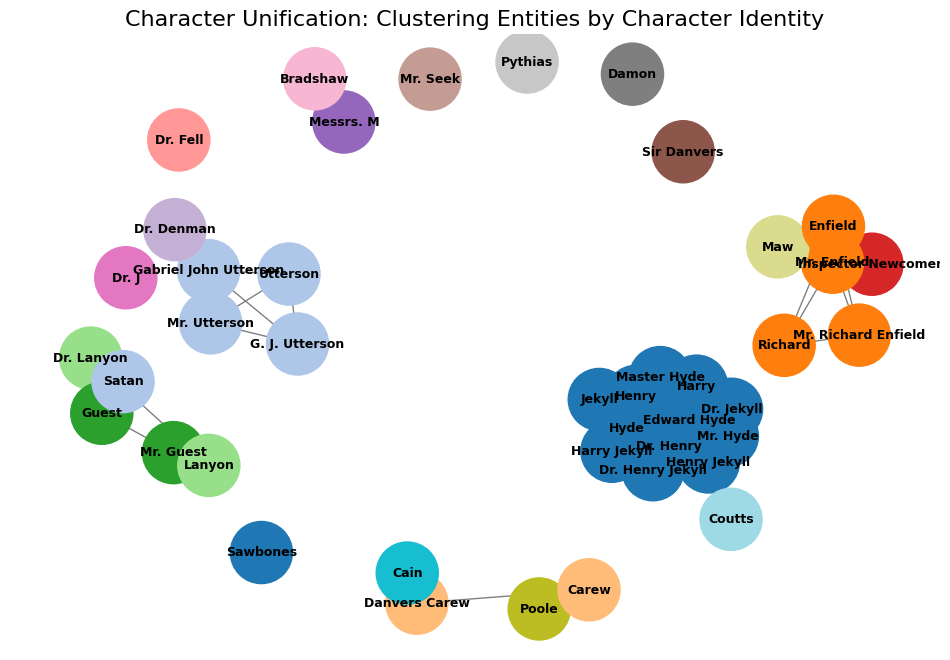

In [63]:
palette = sns.color_palette("hsv", 35)

cmap = ListedColormap(palette)

G = nx.Graph()


for idx, row in df.iterrows():
    G.add_node(row['entity'], group=row['entity_group'])

for idx1, row1 in df.iterrows():
    for idx2, row2 in df.iterrows():
        if row1['entity_group'] == row2['entity_group'] and row1['entity'] != row2['entity']:
            G.add_edge(row1['entity'], row2['entity'])


partition = nx.community.greedy_modularity_communities(G)
communities = {}
for idx, comm_nodes in enumerate(partition):
    for node in comm_nodes:
        communities[node] = idx


nx.set_node_attributes(G, communities, 'community')


plt.figure(figsize=(12, 8))

pos = nx.spring_layout(G, k=0.7, iterations=50)


node_colors = [plt.cm.tab20(communities[node] % 20) for node in G.nodes()]

nx.draw_networkx_nodes(G, pos, node_size=2000, node_color=node_colors)
nx.draw_networkx_edges(G, pos, edge_color='gray')

nx.draw_networkx_labels(G, pos, font_size=9, font_weight="bold")
plt.title("Character Unification: Clustering Entities by Character Identity", fontsize=16)
plt.savefig(os.path.join(output_directory, book_title+'_clustering_entities.png'), format='png', bbox_inches='tight')


plt.axis('off')
plt.show()

In [ ]:
with open(os.path.join(output_directory, book_title+'_clustered_entities.csv'), 'w', newline='') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerow(['Community', 'Entity'])

    for idx, community in enumerate(partition):
        for entity in community:
            writer.writerow([idx, entity])

    community_nodes = set.union(*map(set, partition)) 
    for node in G.nodes():
        if node not in community_nodes:
            writer.writerow(['SingleNode', node])

entities = pd.read_csv(os.path.join(output_directory, book_title+'_clustered_entities.csv'))

In [65]:
book_coref_resolved = ''.join(updated_docs)
with open(os.path.join(output_directory, book_title+"_coref_resolved.txt"), "w") as file:
    file.write(book_coref_resolved)


In [66]:
def conta_occorrenze(testo):
    occorrenze = {}
    for entità in entities['Entity']:

        pattern = r'\b' + re.escape(entità) + r'\b'
        conteggio = len(re.findall(pattern, testo))
        occorrenze[entità] = conteggio
    return occorrenze

conteggio_entità = conta_occorrenze(book_coref_resolved)

entità_cluster = entities.groupby('Community')['Entity'].apply(lambda x: x.map(conteggio_entità).idxmax()).to_dict()
entities['Reference_Entity'] = entities['Community'].map(entità_cluster)
def get_entity(df, index):
    reference_index = df.loc[index, 'Reference_Entity']  # Ottenere l'indice di riferimento
    entity = df.loc[reference_index, 'Entity']  # Ottenere l'entità associata all'indice di riferimento
    return entity

entities['Associated_Entity'] = entities.apply(lambda row: get_entity(entities, row.name), axis=1)

entities

,Community,Entity,Reference_Entity,Associated_Entity
0,0,Dr. Henry Jekyll,11,Jekyll
1,0,Dr. Henry,11,Jekyll
2,0,Harry Jekyll,11,Jekyll
3,0,Master Hyde,11,Jekyll
4,0,Edward Hyde,11,Jekyll
5,0,Henry,11,Jekyll
6,0,Henry Jekyll,11,Jekyll
7,0,Dr. Jekyll,11,Jekyll
8,0,Harry,11,Jekyll
9,0,Mr. Hyde,11,Jekyll


In [67]:
name_list=entities.Entity.unique()

def extract_sentences(text, entity_list):
    nlp = spacy.load("en_core_web_sm")
    nlp.max_length=len(text)
    doc = nlp(text)
    result_data = []    
    for sentence in doc.sents:
        sentence_text = sentence.text.lower()
        entities_found = []

        sorted_entities = sorted(entity_list, key=len, reverse=True)

        for entity in sorted_entities:
            entity_lower = entity.lower()
            pattern = r'\b' + re.escape(entity_lower) + r'\b'
            if re.search(pattern, sentence_text):
                sentence_text = re.sub(re.escape(entity_lower), '', sentence_text)
                entities_found.append(entity)
        
        if entities_found:
            result_data.append({'Sentence': sentence.text, 'Entities': entities_found})

    return result_data

result_data = extract_sentences(book_coref_resolved, name_list)

df = pd.DataFrame(result_data)

In [68]:
df.head(30)

,Sentence,Entities
0,{\rtf1\ansi\ansicpg1252\cocoartf2636\n\cocoate...,[Mr. Utterson]
1,Mr. Utterson was austere with Mr. Utterson; dr...,[Mr. Utterson]
2,But Mr. Utterson had an approved\\ntolerance f...,[Mr. Utterson]
3,"""I incline to Cain's heresy,""\\nMr. Utterson u...","[Mr. Utterson, Cain]"
4,"And to such as these, so long as these came ab...",[Mr. Utterson]
5,No doubt the feat was easy to Mr. Utterson; fo...,[Mr. Utterson]
6,His friends were those of his own blood or tho...,[Mr. Utterson]
7,"Hence, no doubt the\\nbond that united Mr. Utt...","[Mr. Richard Enfield, Mr. Utterson]"
8,Tramps slouched into the recess and struck mat...,[Mr. Enfield]
9,Mr. Enfield asked; and when his companion had\...,[Mr. Enfield]


In [69]:
from itertools import combinations
from collections import Counter

def get_entity_pairs(entities_list):
    pairs = list(combinations(sorted(entities_list), 2))
    return pairs


pairs = df['Entities'].apply(get_entity_pairs)

pair_counts = Counter(pair for sublist in pairs for pair in sublist)


pair_df = pd.DataFrame.from_dict(pair_counts, orient='index', columns=['Count']).reset_index()


pair_df[['Entity1', 'Entity2']] = pair_df['index'].apply(pd.Series)

pair_df.drop(columns=['index'], inplace=True)


pair_df

,Count,Entity1,Entity2
0,1,Cain,Mr. Utterson
1,1,Mr. Richard Enfield,Mr. Utterson
2,1,Coutts,Satan
3,3,Mr. Enfield,Mr. Utterson
4,4,Enfield,Mr. Utterson
...,...,...,...
96,1,Carew,Hyde
97,1,Carew,Lanyon
98,1,Edward Hyde,Sir Danvers
99,1,Bradshaw,Dr. Jekyll


In [70]:
pair_df = pair_df.merge(entities, how='left', left_on='Entity1', right_on='Entity')
pair_df = pair_df.rename(columns={'representative_entity': 'Rep_Entity1'}).drop('Entity', axis=1)
pair_df = pair_df.merge(entities, how='left', left_on='Entity2', right_on='Entity')
pair_df = pair_df.rename(columns={'representative_entity': 'Rep_Entity2'}).drop('Entity', axis=1)
if 'Rep_Entity1' in pair_df.columns:
    pair_df['Entity1'] = pair_df['Rep_Entity1']
if 'Rep_Entity2' in pair_df.columns:
    pair_df['Entity2'] = pair_df['Rep_Entity2']
pair_df = pair_df.drop(['Rep_Entity1', 'Rep_Entity2'], axis=1, errors='ignore')
pair_df

,Count,Entity1,Entity2,Community_x,Reference_Entity_x,Associated_Entity_x,Community_y,Reference_Entity_y,Associated_Entity_y
0,1,Cain,Mr. Utterson,18,38,Cain,1,13,Utterson
1,1,Mr. Richard Enfield,Mr. Utterson,2,17,Enfield,1,13,Utterson
2,1,Coutts,Satan,19,39,Coutts,21,41,Satan
3,3,Mr. Enfield,Mr. Utterson,2,17,Enfield,1,13,Utterson
4,4,Enfield,Mr. Utterson,2,17,Enfield,1,13,Utterson
...,...,...,...,...,...,...,...,...,...
96,1,Carew,Hyde,3,20,Carew,0,11,Jekyll
97,1,Carew,Lanyon,3,20,Carew,5,24,Lanyon
98,1,Edward Hyde,Sir Danvers,0,11,Jekyll,10,30,Sir Danvers
99,1,Bradshaw,Dr. Jekyll,13,33,Bradshaw,0,11,Jekyll


In [71]:
pair_df = pair_df[['Count', 'Associated_Entity_x', 'Associated_Entity_y']]

pair_df = pair_df.groupby(['Associated_Entity_x', 'Associated_Entity_y']).sum().reset_index()
pair_df=pair_df[pair_df['Associated_Entity_x']!=pair_df['Associated_Entity_y']]
pair_df['Sorted_Pair'] = pair_df.apply(lambda row: tuple(sorted([row['Associated_Entity_x'], row['Associated_Entity_y']])), axis=1)

grouped_df = pair_df.groupby('Sorted_Pair')['Count'].sum().reset_index()

grouped_df[['Associated_Entity_x', 'Associated_Entity_y']] = pd.DataFrame(grouped_df['Sorted_Pair'].tolist(), index=grouped_df.index)
grouped_df.drop(columns=['Sorted_Pair'], inplace=True)

pair_df = grouped_df[['Associated_Entity_x', 'Associated_Entity_y', 'Count']]

In [72]:
count_df=pair_df
count_df['Normalized_Count'] = count_df['Count'] / count_df['Count'].sum()
count_df_gephi = count_df.rename(columns={'Associated_Entity_x': 'Source', 'Associated_Entity_y': 'Target', 'Count':'Weight'})

count_df_gephi.head()

/var/folders/l7/63dn96zn3sb_06tmfywphyg00000gn/T/ipykernel_865/1003943009.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  count_df['Normalized_Count'] = count_df['Count'] / count_df['Count'].sum()


,Source,Target,Weight,Normalized_Count
0,Bradshaw,Jekyll,2,0.013072
1,Bradshaw,Poole,1,0.006536
2,Cain,Utterson,1,0.006536
3,Carew,Jekyll,4,0.026144
4,Carew,Lanyon,1,0.006536


In [73]:
import networkx as nx
G = nx.from_pandas_edgelist(count_df_gephi, 'Source', 'Target', edge_attr='Weight', create_using=nx.Graph())

for u, v, d in G.edges(data=True):
    d['weight'] = d['Weight']

nx.write_gexf(G, os.path.join(output_directory, book_title+'_co_occurrences.gexf'))

In [74]:
unique_values = pd.unique(pd.concat([pair_df['Associated_Entity_x'], pair_df['Associated_Entity_y']]))

unique_values_list = list(unique_values)

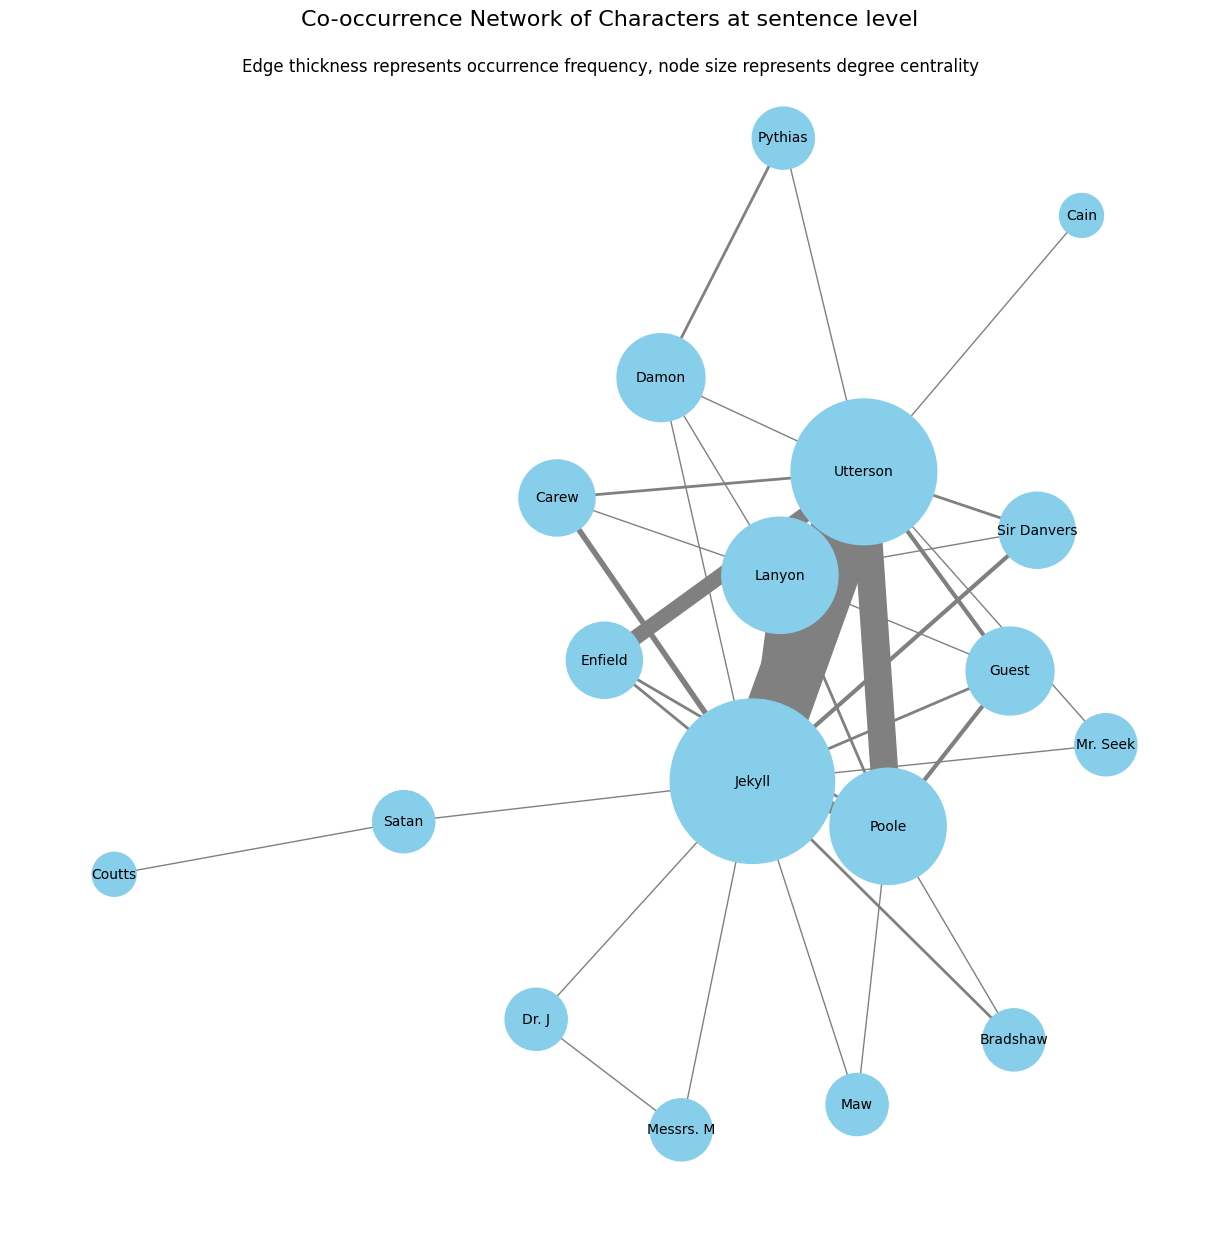

In [81]:
G = nx.from_pandas_edgelist(count_df, 'Associated_Entity_x', 'Associated_Entity_y', ['Count'])
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
close_centrality = nx.closeness_centrality(G)
pr = nx.pagerank(G, alpha=0.8)

node_size = [1000 * G.degree(n) for n in G.nodes()]

# Imposta lo spessore degli archi in base al peso delle co-occorrenze
edge_width = [d['Count'] for u, v, d in G.edges(data=True)]


plt.figure(figsize=(12, 12))
pos = nx.kamada_kawai_layout(G)
nx.draw(G, pos, with_labels=True, node_size=node_size, font_size=10, font_color='black', node_color='skyblue', edge_color='gray', width=edge_width)
plt.title('Co-occurrence Network of Characters at sentence level', fontsize=16)
plt.suptitle('Edge thickness represents occurrence frequency, node size represents degree centrality', fontsize=12, y=0.98)


image_path = os.path.join(output_directory, book_title+'_network_graph.png')
plt.savefig(image_path, format='png', bbox_inches='tight')


dc_calculations = []
bc_calculations = []
close_calculations = []
pg_rank_calculations = []
nodes = list(G.nodes)
for node in nodes:
    dc_calculations.append(degree_centrality[node])
    bc_calculations.append(betweenness_centrality[node])
    close_calculations.append(close_centrality[node])
    pg_rank_calculations.append(pr[node])

centrality_data = pd.DataFrame({
    "Node": nodes,
    "Degree-Centrality": dc_calculations,
    "Betweenness-Centrality": bc_calculations,
    "Closeness-Centrality": close_calculations,
    "PageRank": pg_rank_calculations
})

plt.show()
plt.close()

In [76]:
centrality_data.sort_values(by=['Degree-Centrality'], ascending=False)


,Node,Degree-Centrality,Betweenness-Centrality,Closeness-Centrality,PageRank
1,Jekyll,0.823529,0.584559,0.850000,0.177311
4,Utterson,0.647059,0.257353,0.708333,0.136057
2,Poole,0.411765,0.050245,0.607143,0.086665
6,Lanyon,0.411765,0.022059,0.607143,0.083530
9,Damon,0.235294,0.026961,0.548387,0.053356
14,Guest,0.235294,0.000000,0.548387,0.050589
13,Enfield,0.176471,0.000000,0.531250,0.041043
17,Sir Danvers,0.176471,0.000000,0.531250,0.040685
5,Carew,0.176471,0.000000,0.531250,0.040685
8,Satan,0.117647,0.117647,0.500000,0.044313


In [77]:
print('Number of edges: ',G.number_of_edges())
print('Number of nodes: ',G.number_of_nodes())
print('Number of possible edges: ',int((G.number_of_nodes())*(G.number_of_nodes()-1)/2))
print('Density: ',round(G.number_of_edges()/((G.number_of_nodes())*(G.number_of_nodes()-1)/2)*100,2),'%')

Number of edges:  36
Number of nodes:  18
Number of possible edges:  153
Density:  23.53 %


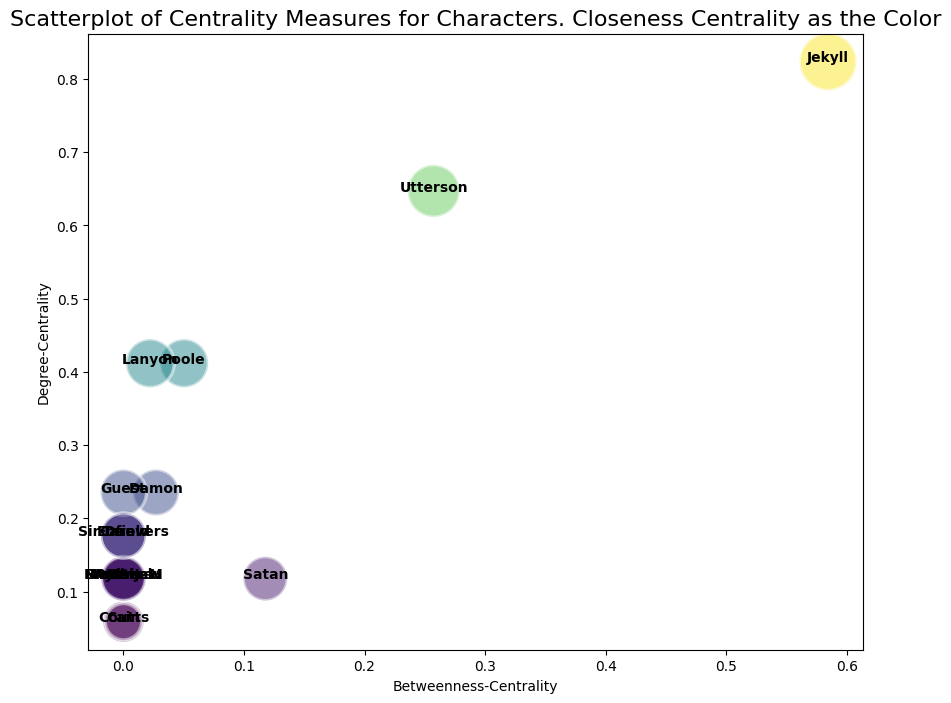

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt
centrality_data['Closeness-Centrality_1000']=centrality_data['Closeness-Centrality']*2000
c_sorted = sorted(centrality_data['Degree-Centrality'], reverse=True)
plt.figure(figsize = (10,8))

ax = sns.scatterplot(data=centrality_data, y='Degree-Centrality', x='Betweenness-Centrality',alpha=0.5,s = centrality_data['Closeness-Centrality_1000'], c=centrality_data['Degree-Centrality'])

for line in range(0,centrality_data.shape[0]):
    try:
         ax.text(centrality_data['Betweenness-Centrality'][line], centrality_data['Degree-Centrality'][line],centrality_data['Node'][line], horizontalalignment='center', size='medium', color='black', weight='semibold')
    except:
        line+=1
plt.title('Scatterplot of Centrality Measures for Characters. Closeness Centrality as the Color', fontsize=16)


plt.savefig(os.path.join(output_directory, book_title+'_scatterplot_centrality_data.png'), dpi=300) 